### 1.1 configuration

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'  # default font, for filter warning

### 1.2 data pre-process
In this part, loads all users’ trajectorires, keep GPS points that are in defined Beijing region and have at least 3 valid points, keeps users who have at least one valid trajectory, adn save the file.

In [5]:
data_path = "Geolife_Trajectories_1.3/Data/"
users = [u for u in os.listdir(data_path) if u.isdigit()] # each user has a folder with all trajectories

In [7]:
# filter trajectories not in Beijing
user_trajectory = {}
eligible_users = []
temp_trajectory = {}  # temporary storage before filtering

# iterate over all users
for user in users:
    user_path = os.path.join(data_path, user, "Trajectory")
    user_traj_list = []  # store this user's valid trajectories
    
    # terate over each trajectory file
    for trajectory in os.listdir(user_path):
        trajectory_path = os.path.join(user_path, trajectory)
        trajectory_l = []
        points = open(trajectory_path, "r").read().strip().split("\n")[6:]

        # filter points within Beijing region
        for point in points:
            point = point.split(",")
            point = (float(point[0]), float(point[1]), float(point[4]))
            # beijing's range
            if 39.75 <= point[0] <= 40.1 and 116.15 <= point[1] <= 116.6:
                trajectory_l.append(point)

        # keep the entire filtered trajectory if >= 3 points
        if len(trajectory_l) >= 3:
            user_traj_list.append(trajectory_l)

    # users that has at least one valid trajectory are eligible
    if len(user_traj_list) > 0:
        temp_trajectory[user] = user_traj_list
        eligible_users.append(user)

# keep only eligiable users
user_trajectory = {u: temp_trajectory[u] for u in eligible_users}

for user, trajs in user_trajectory.items():
    user_trajectory[user] = [
        [(lat, lon) for lat, lon, *_ in traj]  # keep only first two elements
        for traj in trajs]

# save to pickle
pickle.dump(user_trajectory, open("Beijing_user_trajectory.pkl", "wb"))

In [3]:
# re-load data if needed, restart here
with open("Beijing_user_trajectory.pkl", "rb") as f:
    user_trajectory = pickle.load(f)

randomly selects 50 users for testing and debug

In [19]:
# get all user IDs
'''
all_users = list(user_trajectory.keys())

# Randomly select up to 50 users
sample_size = 50
sampled_users = random.sample(all_users, sample_size)

# Create a new dictionary for sampled users
user_trajectory = {user: user_trajectory[user] for user in sampled_users}
'''

'\nall_users = list(user_trajectory.keys())\n\n# Randomly select up to 50 users\nsample_size = 50\nsampled_users = random.sample(all_users, sample_size)\n\n# Create a new dictionary for sampled users\nuser_trajectory = {user: user_trajectory[user] for user in sampled_users}\n'

### 1.3 data explore and visiualization

In [9]:
num_users = len(user_trajectory)
print(f"Number of valid users: {num_users}")

user_traj_count = {user: len(trajs) for user, trajs in user_trajectory.items()}

total_trajectories = sum(user_traj_count.values())
print(f"Total number of trajectories: {total_trajectories}")
print(f"Average number of trajectories per user: {(round(total_trajectories/num_users))}")

Number of valid users: 179
Total number of trajectories: 17075
Average number of trajectories per user: 95


/var/folders/n7/vz1f3ct91hdgrxgt12vn6_s40000gn/T/ipykernel_26798/1767430662.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')


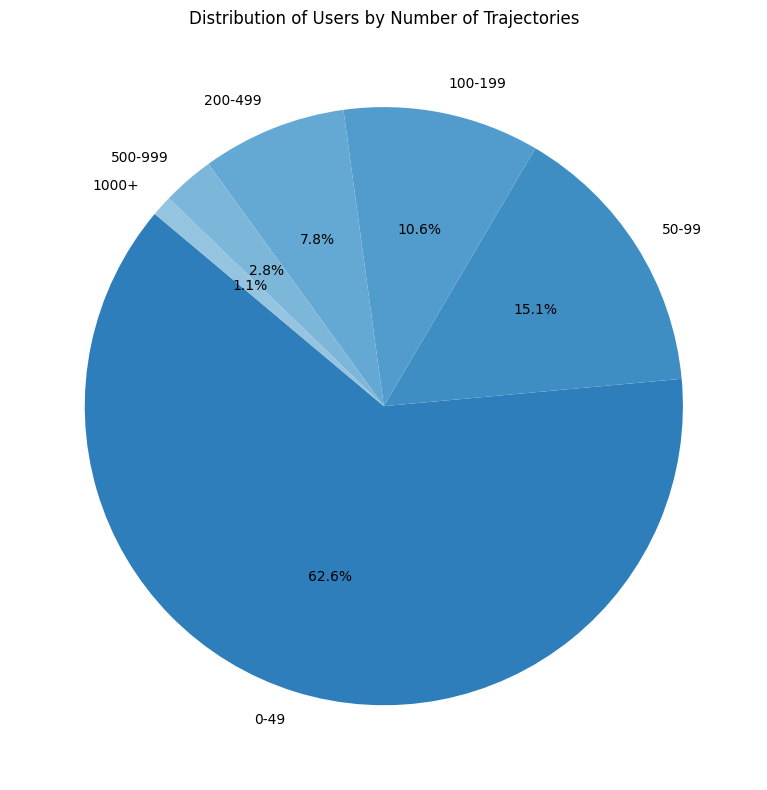

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Define ranges
ranges = [0, 50, 100, 200, 500, 1000, max(traj_counts_sorted)+1]
range_labels = ['0-49', '50-99', '100-199', '200-499', '500-999', '1000+']

# Count number of users in each range
range_counts = [0] * (len(ranges)-1)
for count in traj_counts_sorted:
    for i in range(len(ranges)-1):
        if ranges[i] <= count < ranges[i+1]:
            range_counts[i] += 1
            break

# Generate reversed gradient colors, lighter shades of blue
cmap = cm.get_cmap('Blues')
colors = cmap(np.linspace(0.7, 0.4, len(range_counts)))  # lighter gradient

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(range_counts, labels=range_labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Distribution of Users by Number of Trajectories")
plt.tight_layout()
plt.savefig("Users_Trajectory_Distribution_Pie_Blue_Lighter.png", dpi=300)
plt.show()


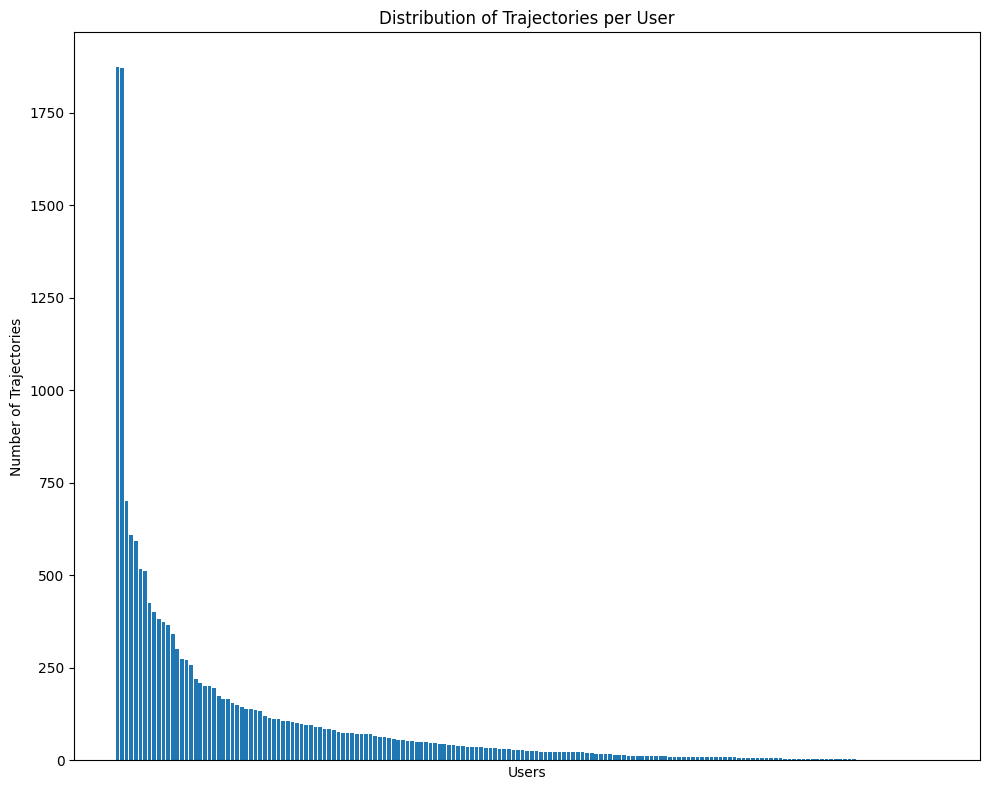

In [15]:
# storing number of trajectories for each user
sorted_users = sorted(user_traj_count.items(), key=lambda x: x[1], reverse=True)
users_sorted, traj_counts_sorted = zip(*sorted_users)

plt.figure(figsize=(10,8))
plt.bar(users_sorted, traj_counts_sorted)
plt.xlabel("Users")
plt.ylabel("Number of Trajectories")
plt.title("Distribution of Trajectories per User")
plt.xticks([])
plt.tight_layout()
plt.savefig("Distribution of Trajectories per User.png", dpi=300)
plt.show()

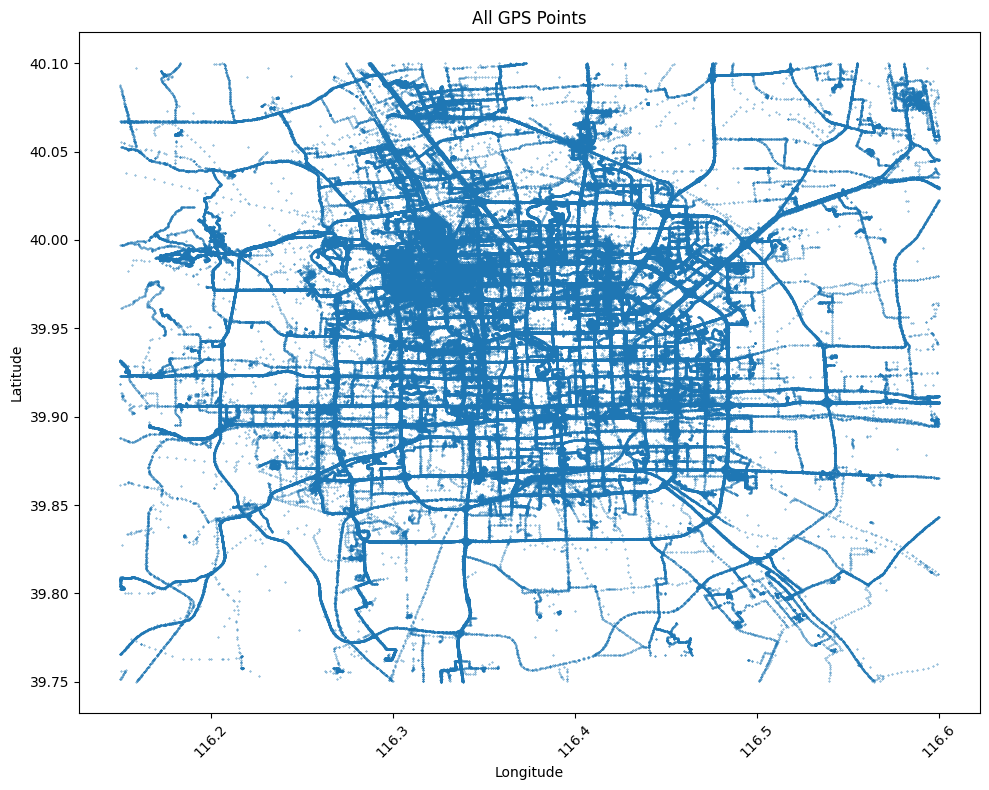

In [31]:
all_points = [p for trajs in user_trajectory.values() for traj in trajs for p in traj]

# sample every 10th point to reduce plotting density
n = 10
l_point = all_points[::n]
lat_all = [i[0] for i in l_point]
lon_all = [i[1] for i in l_point]

plt.figure(figsize=(10,8))
plt.scatter(lon_all, lat_all, s=0.1)
plt.title("All GPS Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("All GPS Points.png", dpi=300)
plt.show()

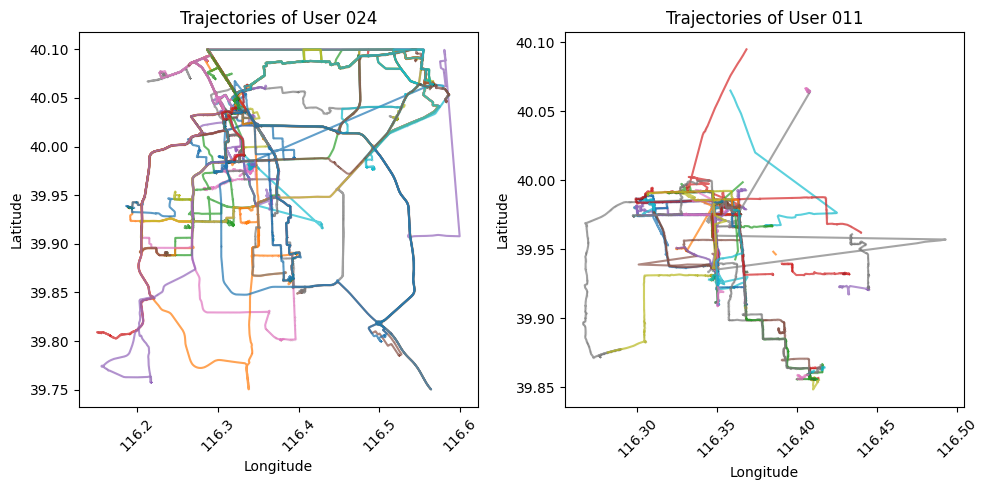

In [45]:
user_ids = ["024", "011"]  # one is trajectory average number and other one is median number
fig, axes = plt.subplots(1, 2, figsize=(10,5))

for ax, user_id in zip(axes, user_ids):
    user_trajs = user_trajectory[user_id]
    
    # Plot each trajectory
    for traj in user_trajs:
        lat_traj = [p[0] for p in traj]
        lon_traj = [p[1] for p in traj]
        ax.plot(lon_traj, lat_traj, "o-", markersize=0.01, alpha=0.7)
    
    ax.set_title(f"Trajectories of User {user_id}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.savefig("Trajectories of sample Users.png", dpi=300)
plt.show()

### 2.1 Adding noise logic
**Part 1: Event-level DP for Trajectories (Gaussian Mechanism):**  
Event-level DP focus on sigle location point, simply adding some guassian noise to each point.  
Reference: [The Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf), Cynthia Dwork and Aaron Roth.(Theorem 3.22 page 53)
  $$\tilde{x} = x + \mathcal{N}(0, \sigma^2), \quad \tilde{y} = y + \mathcal{N}(0, \sigma^2)$$
* $\sigma$ controls the noise magnitude

**How to set the epsilon range?** To satisfy (ϵ,δ)-Differential Privacy using Gaussian noise, the standard deviation σ must satisfy
  $$\sigma \geq \frac{\ Sensitivity \cdot \sqrt{2 \ln(1.25/\delta)}}{\epsilon}$$
* Sensitivity: The maximum Euclidean distance a user can move.
* $\delta$ : A common standard is $10^{-5}$.
* $\epsilon$: target privacy budget.



**Part 2: Geo-Indistinguishability (Planar Laplace Mechanism)**  
Reference: [Geo-Indistinguishability: Differential Privacy for Location-Based Systems](https://arxiv.org/abs/1212.1984), Miguel E. Andrés, Nicolás E. Bordenabe, Konstantinos Chatzikokolakis, Catuscia Palamidessi Conference: ACM CCS 2013 (Computer & Communications Security)  
$$(x', y') = x + r \cos \theta, \quad y + r \sin \theta$$
* $r$ sampled from Laplace with scale $b = \frac{1}{\varepsilon}$
* $\theta \sim U[0, 2\pi)$

**How to set the epsilon range?** 
$$\epsilon = \frac{\ell}{r}$$
* $r$ : The distance within which you want to protect the user.
* $\ell$ (Privacy Loss): The strength of privacy at that radius. A common standard in the paper is $\ell = \ln(4)$ .


**Part 3: Trajectory-level DP (Gaussian Mechanism)**  
Similar with Event-level DP, it adds guassian noise not to each point,  but to the whole trajectory, protecting the full trajectory. It often requires much larger σ than event-level DP because the entire dataset is protected.

* Add Gaussian noise to each trajectory (same $\sigma_m$ for the whole trajectory):

    $$\tilde{dx}_i = dx_i + \mathcal{N}(0, \sigma_m^2), \quad \tilde{dy}_i = dy_i + \mathcal{N}(0, \sigma_m^2)$$

* $\sigma_m$ controls the trajectory-level noise magnitude


In [5]:
# Part 1: Event-level DP for Trajectories (Add Gaussian Noise to each point)
def gaussian_noise_point(point, sigma):
    lat, lon = point
    noisy_lat = lat + np.random.normal(0, sigma)
    noisy_lon = lon + np.random.normal(0, sigma)
    return (noisy_lat, noisy_lon)
def gaussian_noise_trajectory(traj, sigma):
    return [gaussian_noise_point(p, sigma) for p in traj]
# how to convert epsilons to sigmas
def get_sigma_gaussian(epsilons, delta = 1e-5, sensitivity = 100):
    sigmas = []
    for epsilon in epsilons:
        numerator = sensitivity * np.sqrt(2 * np.log(1.25 / delta))
        sigma_meters = numerator / epsilon
        
        sigma = sigma_meters / 111000
        sigmas.append(sigma)
    return sigmas


# Part 2: Geo-Indistinguishability (planar Laplace)
def geoind_noise_point(point, epsilon):
    meter_per_degree = 111000
    lat, lon = point
    # sample planar Laplace noise in meter
    theta = np.random.uniform(0, 2*np.pi)
    r = np.random.gamma(shape=2, scale=1/epsilon)  # r in meters

    # convert noise to degrees
    dlat = r * np.cos(theta) / meter_per_degree
    dlon = r * np.sin(theta) / (meter_per_degree * np.cos(np.radians(lat)))

    noisy_lat = lat + dlat
    noisy_lon = lon + dlon
    return (noisy_lat, noisy_lon)

def geoind_noise_trajectory(traj, epsilon=1.0):
    noisy = [geoind_noise_point(p, epsilon) for p in traj]
    return noisy


# Part 3: Trajectory-level DP (user-level DP)
def trajectory_to_meters(traj):
    origin_lat, origin_lon = traj[0]
    traj_m = []
    for lat, lon in traj:
        dy = (lat - origin_lat) * 111000
        dx = (lon - origin_lon) * (111000 * np.cos(np.radians(origin_lat)))
        traj_m.append((dx, dy))
    return traj_m, origin_lat, origin_lon

def trajectory_to_degrees(traj_m, origin_lat, origin_lon):
    traj_deg = []
    for dx, dy in traj_m:
        lat = origin_lat + dy / 111000
        lon = origin_lon + dx / (111000 * np.cos(np.radians(origin_lat)))
        traj_deg.append((lat, lon))
    return traj_deg

def trajectory_dp_noise(traj, epsilon=1.0, delta=1e-5, sensitivity_m=100):
    # convert trajectory to meters
    traj_m, origin_lat, origin_lon = trajectory_to_meters(traj)

    # compute sigma (Gaussian mechanism)
    sigma_m = sensitivity_m * np.sqrt(2 * np.log(1.25 / delta)) / epsilon

    # Add noise in meters
    noisy_traj_m = []
    for dx, dy in traj_m:
        noisy_dx = dx + np.random.normal(0, sigma_m)
        noisy_dy = dy + np.random.normal(0, sigma_m)
        noisy_traj_m.append((noisy_dx, noisy_dy))

    # back to degrees
    noisy_traj = trajectory_to_degrees(noisy_traj_m, origin_lat, origin_lon)

    return noisy_traj

Apply noise

In [7]:
def apply_gaussian_multi(user_trajectory, epsilons):
    # conver epsilons to sigmas first
    sigmas = get_sigma_gaussian(epsilons)
    noisy_results = {}
    for i, sigma in enumerate(sigmas):
        epsilon = epsilons[i]
        print(f"Applying event-level gaussian noise: epsilon={epsilon}")
        noisy_results[epsilon] = {user: [gaussian_noise_trajectory(traj, sigma=sigma) for traj in trajs]
                                for user, trajs in user_trajectory.items()}
    print("All event-level noise applied.\n")
    return noisy_results


def apply_geoind_multi(user_trajectory, epsilons):
    noisy_results = {}
    for eps in epsilons:
        print(f"Applying Geo-Ind noise: noise level={eps}")
        noisy_results[eps] = {user: [geoind_noise_trajectory(traj, epsilon=eps) for traj in trajs]
                              for user, trajs in user_trajectory.items()}
    print("All Geo-Ind noise applied.\n")
    return noisy_results


def apply_traj_multi(user_trajectory, epsilon_list, delta=1e-5, sensitivity_m=100):
    noisy_results = {}
    for eps in epsilon_list:
        print(f"Applying Trajectory-level gaussian noise: epsilon={eps}")
        noisy_results[eps] = {user: [trajectory_dp_noise(traj, epsilon=eps, delta=delta, sensitivity_m=sensitivity_m)
                                     for traj in trajs] 
                              for user, trajs in user_trajectory.items()}
    print("All trajectory-level noise applied.\n")
    return noisy_results

### 2.2 Quantitative Utility Metrics
This part follow the standard practice in trajectory data utility evaluation by using spatial‑distance metrics (e.g., **Hausdorff distance**) and distribution-based density similarity, as recommended in [**Chang et al., 2024**](https://www.vldb.org/pvldb/vol17/p2293-qi.pdf); [**SoK: Differentially Private Publication of Trajectory Data, 2023**](https://javier-parra.staff.upc.edu/publications/miranda23PETS.pdf); [**Semantic‑Geographic Trajectory Pattern Mining, 2014**](https://www.mdpi.com/2220-9964/6/7/212)]. I compute histogram-based density similarity via **Jensen–Shannon divergence**, a well-established symmetric divergence measure for probability distributions [**Jensen–Shannon Divergence**](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence); [**Nielsen, 2007**](https://pmc.ncbi.nlm.nih.gov/articles/PMC7516653/)]. For privacy risk, I use a heuristic **“closest‑match re‑identification”** approach to approximate the likelihood of an adversary linking noisy trajectories to original ones.

**Part 1: Average Displacement**   
Average displacement measures the pointwise deviation between the original and noisy trajectories. It computes the mean distance between corresponding points in the trajectories.
$$\text{AvgDisp} = \frac{1}{M} \sum_{j=1}^{N} \sum_{i=1}^{\min(n_j, m_j)} d_{\text{haversine}} \left( p_i^{(j)}, q_i^{(j)} \right)$$
* where $M = \sum_{j=1}^{N} \min(n_j, m_j)$ is the total number of matched point pairs.

**Part 2: hausdorff_distance**   
Hausdorff distance quantifies the similarity between two sets of points (trajectories) by capturing the maximum deviation between any point in one trajectory and the closest point in the other trajectory.  
$$d_H(T_1, T_2) = \max \left\{ \sup_{x \in T_1} \inf_{y \in T_2} d(x, y), \quad \sup_{y \in T_2} \inf_{x \in T_1} d(x, y) \right\}.$$

**Part 3: Density Similarity (Jensen–Shannon Divergence)**   
Density similarity compares the overall spatial distributions of points in the original and noisy trajectories. Two-dimensional histograms are constructed over the spatial domain, normalized to probability distributions, and compared using the Jensen–Shannon divergence (JSD).
$$\text{JSD}(P \| Q) = \frac{1}{2} D_{\text{KL}}(P \| M) + \frac{1}{2} D_{\text{KL}}(Q \| M), \quad M = \frac{1}{2}(P + Q)$$

**Part 4: Re-identification Risk**  
Re-identification risk estimates the likelihood that a noisy trajectory can be correctly matched to its original trajectory. For each noisy trajectory, the closest original trajectory is identified based on average pointwise distance. The fraction of noisy trajectories correctly matched is reported as the risk. In this project, I mainly apply user level, which means that determine whether a noised trajecotry belong to the person. 
$$\text{ReID\_risk} = \frac{1}{N} \sum_{j=1}^{N} \mathbf{1}(i^* = j)$$
* where $i^*$ is the index of the closest original trajectory.

In [9]:
# average_displacement
def average_displacement(orig_trajs, noisy_trajs):
    traj_disps = []
    for orig_list, noisy_list in zip(orig_trajs, noisy_trajs):
        min_len = min(len(orig_list), len(noisy_list))
        if min_len == 0:
            continue
        disps = [haversine(orig_list[i], noisy_list[i]) for i in range(min_len)]
        traj_disps.append(np.mean(disps))
    return np.mean(traj_disps) if traj_disps else 0.0

# Hausdorff distance
from scipy.spatial.distance import directed_hausdorff
def hausdorff_distance(traj1, traj2):
    return max(directed_hausdorff(traj1, traj2)[0], directed_hausdorff(traj2, traj1)[0])

# density_similarity
from scipy.spatial.distance import jensenshannon
def density_similarity(orig_points, noisy_points, grid_size=0.001):
    # extract coordinates
    lats = [p[0] for p in orig_points]
    lons = [p[1] for p in orig_points]
    bins_lat = max(int((max(lats) - min(lats)) / grid_size), 1)
    bins_lon = max(int((max(lons) - min(lons)) / grid_size), 1)
    
    hist_orig, _, _ = np.histogram2d(lats, lons, bins=[bins_lat, bins_lon])
    hist_orig = hist_orig.flatten() / hist_orig.sum()
    
    lats_noisy = [p[0] for p in noisy_points]
    lons_noisy = [p[1] for p in noisy_points]
    hist_noisy, _, _ = np.histogram2d(lats_noisy, lons_noisy, bins=[bins_lat, bins_lon])
    hist_noisy = hist_noisy.flatten() / hist_noisy.sum()
    
    return jensenshannon(hist_orig, hist_noisy)


# re-identification Risk
# orig_trajs_by_user and noisy_trajs_by_user are user level dictionary, contain a user's all trajectory
from haversine import haversine
def user_level_reid_risk(orig_trajs_by_user, noisy_trajs_by_user):
    all_orig_trajs = []
    orig_user_labels = []  
    for user, trajs in orig_trajs_by_user.items():
        all_orig_trajs.extend(trajs)
        orig_user_labels.extend([user]*len(trajs))
    
    total_trajs = 0
    correct = 0
    
    for user, noisy_trajs in noisy_trajs_by_user.items():
        for noisy in noisy_trajs:
            # compute avg distance to all original trajectories
            avg_dists = [np.mean([haversine(p1, p2) for p1, p2 in zip(noisy, orig)]) 
                         for orig in all_orig_trajs]
            i_star = np.argmin(avg_dists)
            predicted_user = orig_user_labels[i_star]
            
            if predicted_user == user:
                correct += 1
            total_trajs += 1
    
    return correct / total_trajs

compute matrix for all users across different noise methods.

In [11]:
# get quarters for box-plot
def five_number_summary(values):
    values = np.array(values, dtype=float)
    return {
        "min": float(np.min(values)),
        "q1": float(np.percentile(values, 25)),
        "median": float(np.percentile(values, 50)),
        "q3": float(np.percentile(values, 75)),
        "max": float(np.max(values)),
    }

# average displacement and also for distributiuon check
def compute_average_displacement_all_users(user_trajectory, results_dict):
    disp = {}
    disp_distribution = {}
    for key, noisy_users in results_dict.items():
        disp_list = []
        for user in user_trajectory:
            orig_trajs = user_trajectory[user]
            noisy_trajs = noisy_users[user]
            for orig_traj, noisy_traj in zip(orig_trajs, noisy_trajs):
                min_len = min(len(orig_traj), len(noisy_traj))
                for i in range(min_len):
                    disp_list.append(haversine(orig_traj[i], noisy_traj[i]))

        disp[key] = five_number_summary(disp_list)
        disp_distribution[key] = disp_list

    return disp, disp_distribution


# hausdorff distance
def compute_hausdorff_all_users(user_trajectory, results_dict):
    hd = {}
    for key, noisy_users in results_dict.items():
        hd_list = []
        for user in user_trajectory:
            orig_trajs = user_trajectory[user]
            noisy_trajs = noisy_users[user]
            for orig_traj, noisy_traj in zip(orig_trajs, noisy_trajs):
                hd_list.append(hausdorff_distance(orig_traj, noisy_traj))

        hd[key] = five_number_summary(hd_list)

    return hd


# density_similarity
def compute_density_similarity_all_users(user_trajectory, results_dict):
    density = {}
    for key, noisy_users in results_dict.items():
        ds_list = []
        for user in user_trajectory:
            orig_points = [p for traj in user_trajectory[user] for p in traj]
            noisy_points = [p for traj in noisy_users[user] for p in traj]
            ds_list.append(density_similarity(orig_points, noisy_points))

        density[key] = five_number_summary(ds_list)

    return density



# re-identification risk
from haversine import haversine
def compute_reid_risk_all_users(orig_trajs_by_user, results_dict):
    # Precompute centroids of original trajectories
    orig_centroids = []
    orig_users = []
    for user, trajs in orig_trajs_by_user.items():
        for traj in trajs:
            arr = np.array(traj)  # shape: (points, 2)
            centroid = np.mean(arr, axis=0)
            orig_centroids.append(centroid)
            orig_users.append(user)
    
    reid_probs = {}
    
    for noise_level, noisy_trajs_by_user in results_dict.items():
        probs = []
        for user, noisy_trajs in noisy_trajs_by_user.items():
            for noisy in noisy_trajs:
                arr = np.array(noisy)
                noisy_centroid = np.mean(arr, axis=0)
                
                # Euclidean distance in degrees (approx)
                dists = [np.linalg.norm(noisy_centroid - oc) for oc in orig_centroids]
                predicted_user = orig_users[np.argmin(dists)]
                probs.append(1 if predicted_user == user else 0)
        
        reid_probs[noise_level] = probs

    # Compute probability risk
    prob_risk = {}
    for noise_level, probs in reid_probs.items():  # <-- use reid_probs
        total = len(probs)
        if total > 0:
            risk = sum(probs) / total
        else:
            risk = 0.0
        prob_risk[noise_level] = risk
    
    return prob_risk



Visualize all trajectory-privacy metrics across noise levels.

In [14]:
# visiualize all matrix
import matplotlib.pyplot as plt

def plot_all_metrics(results_dict, method_name="Noise Method"):
    metric_names = ["avg_disp", "hausdorff", "density", "reid"]
    metric_titles = ["Avg Displacement", "Hausdorff Distance", "Density JS", "Re-ID Risk"]

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))  # 4 subplots
    for ax, metric_key, metric_title in zip(axes, metric_names, metric_titles):
        metric_data = results_dict[metric_key]  # dict: noise_level → dict of stats OR float
        noise_levels = list(metric_data.keys())
        
        if metric_key == "reid":
            # Treat keys as strings for x-axis
            x_labels = [str(lvl) for lvl in noise_levels]
            y_values = [metric_data[lvl] for lvl in noise_levels]

            ax.plot(x_labels, y_values, marker='o', linestyle='-', color='tab:blue')
            ax.set_ylabel("Probability")

        else:
            # boxplot using summary stats
            box_data = []
            for lvl in noise_levels:
                stats = metric_data[lvl]
                box_data.append([stats['min'], stats['q1'], stats['median'], stats['q3'], stats['max']])
            ax.boxplot(box_data)
            ax.set_ylabel("Value")

        ax.set_xticklabels([f"{lvl}" for lvl in noise_levels], rotation=45)
        ax.set_title(metric_title)
        ax.set_xlabel("Noise Level")
        ax.grid(True)

    plt.suptitle(f"{method_name} - Metrics Summary", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.savefig("Evaluation matrix.png", dpi=300)
    plt.show()

### 3 Event-Level DP add Guassian noise

How to choose parameter range?

In [16]:
epsilons = [48.4, 9.7, 4.8, 2.4, 1.2, 0.8, 0.6, 0.5]

In [18]:
def epsilons_to_sigmas(epsilons, delta = 1e-5, sensitivity = 100):
    sigmas = []
    for epsilon in epsilons:
        numerator = sensitivity * np.sqrt(2 * np.log(1.25 / delta))
        sigma_meters = numerator / epsilon
        
        sigma = sigma_meters
        sigmas.append(sigma)
    return sigmas
sigmas = epsilons_to_sigmas(epsilons)
sigmas # in meter

[10.009928228523531,
 49.946446006241125,
 100.9334429709456,
 201.8668859418912,
 403.7337718837824,
 605.6006578256736,
 807.4675437675648,
 968.9610525210778]

In [20]:
gaussian_results = apply_gaussian_multi(user_trajectory, epsilons)

Applying event-level gaussian noise: epsilon=48.4
Applying event-level gaussian noise: epsilon=9.7
Applying event-level gaussian noise: epsilon=4.8
Applying event-level gaussian noise: epsilon=2.4
Applying event-level gaussian noise: epsilon=1.2
Applying event-level gaussian noise: epsilon=0.8
Applying event-level gaussian noise: epsilon=0.6
Applying event-level gaussian noise: epsilon=0.5
All event-level noise applied.



### 3.1 Histogram / Heatmap

### 3.1.1 Sample user Heatmap

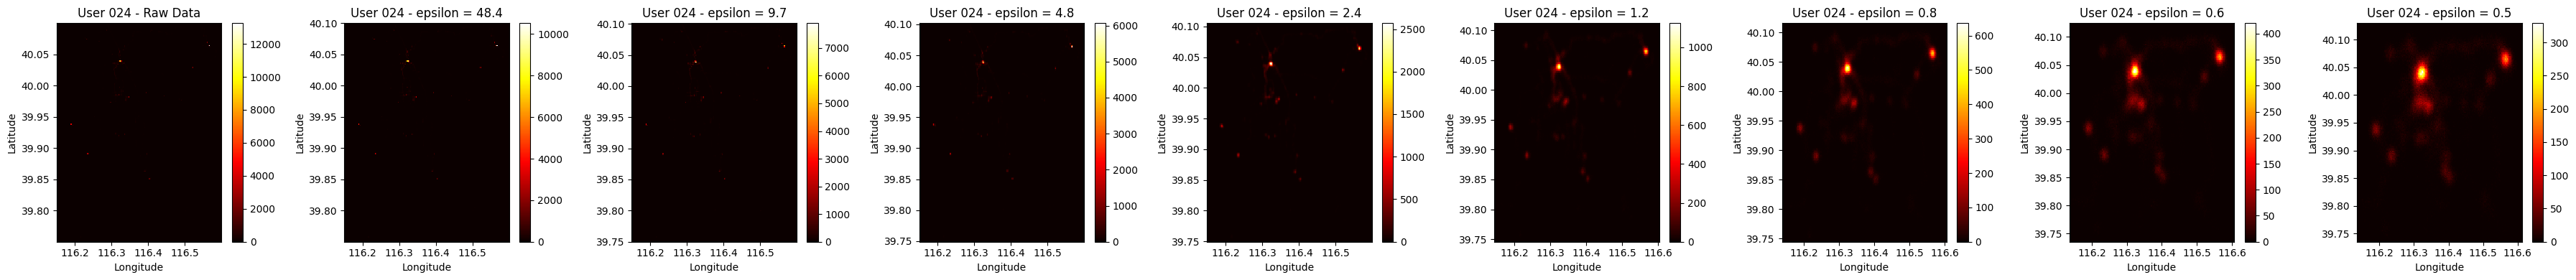

In [21]:
def plot_2d_hist(trajs, ax, title="", bins=200):
    # flatten all trajectories into a single list of points
    all_points = [pt for traj in trajs for pt in traj]
    all_points = np.array(all_points)

    lat = all_points[:, 0]
    lon = all_points[:, 1]

    heat = ax.hist2d(lon, lat, bins=bins, cmap="hot")
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(heat[3], ax=ax)

user_id = "024"
user_trajs = user_trajectory[user_id]
fig, axes = plt.subplots(1, len(epsilons) + 1, figsize=(4*(len(epsilons)+1), 4))

# raw data for this user
plot_2d_hist(user_trajs, axes[0], title=f"User {user_id} - Raw Data")

# plot niose data for each sigma for the sample user
for i, epsilon in enumerate(epsilons):    
    noisy_trajs = gaussian_results[epsilon][user_id]  # only this user's noisy trajectories
    plot_2d_hist(noisy_trajs, axes[i+1], title=f"User {user_id} - epsilon = {epsilon}")

plt.tight_layout()
plt.savefig("Heatmap for sample user.png", dpi=500)
plt.show()


### 3.1.2 All users Heatmap

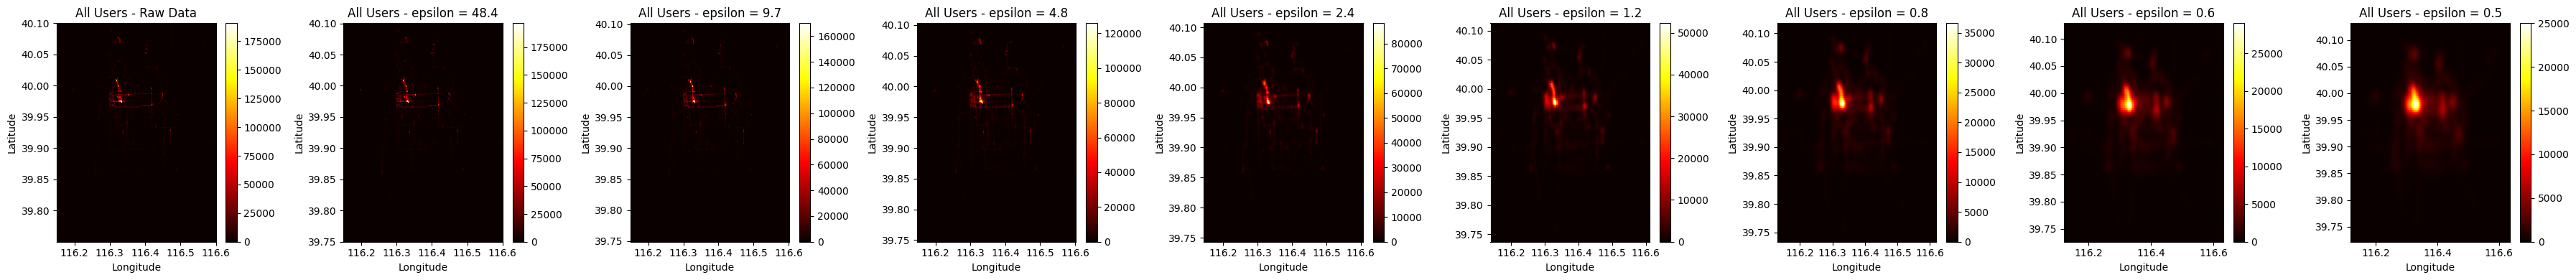

In [124]:
def plot_2d_hist(trajs, ax, title="", bins=200):
    all_points = [pt for traj in trajs for pt in traj]
    all_points = np.array(all_points)

    lat = all_points[:, 0]
    lon = all_points[:, 1]

    heat = ax.hist2d(lon, lat, bins=bins, cmap="hot")
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(heat[3], ax=ax)

all_raw_trajs = [traj for user_trajs in user_trajectory.values() for traj in user_trajs]

fig, axes = plt.subplots(1, len(epsilons) + 1, figsize=(4*(len(epsilons)+1), 4))

# raw data for all users
plot_2d_hist(all_raw_trajs, axes[0], title="All Users - Raw Data")

# Plot privatized data for each sigma for all users
for i, epsilon in enumerate(epsilons):
    all_noisy_trajs = [traj for trajs_per_user in gaussian_results[epsilon].values() for traj in trajs_per_user]
    plot_2d_hist(all_noisy_trajs, axes[i+1], title=f"All Users - epsilon = {epsilon}")


plt.tight_layout()
plt.savefig("Heatmap for all user.png", dpi=500)
plt.show()

### 3.2 Scatter plots

### 3.2.1 separate plot

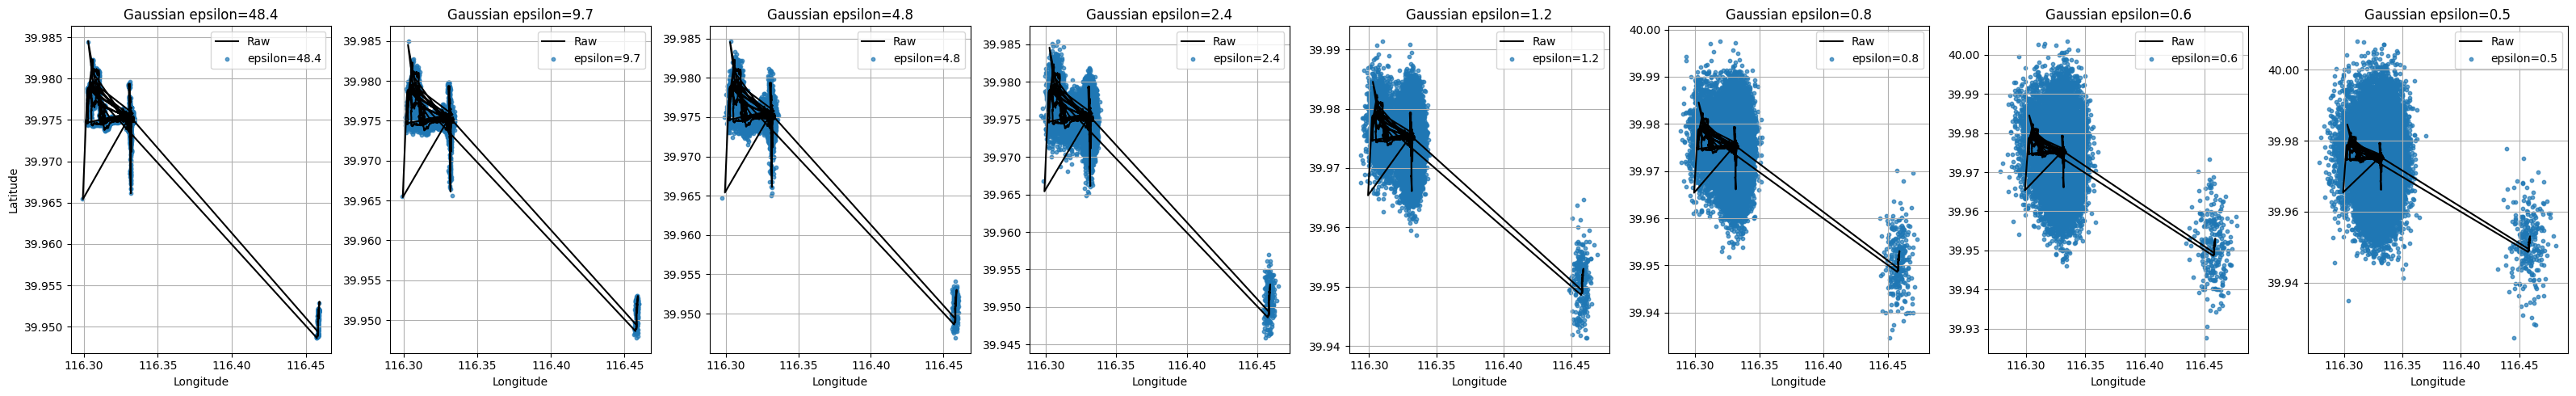

In [132]:
user_id = "075"
user_trajs = user_trajectory[user_id]

lat_orig = [p[0] for traj in user_trajs for p in traj]
lon_orig = [p[1] for traj in user_trajs for p in traj]

fig, axes = plt.subplots(1, len(epsilons), figsize=(4*len(epsilons), 5))
for i, epsilon in enumerate(epsilons):
    ax = axes[i]
    # raw base layer
    ax.plot(lon_orig, lat_orig, color="black", linewidth=1.5, label="Raw")
    
    noisy_trajs = gaussian_results[epsilon][user_id]
    lat_noisy = [p[0] for traj in noisy_trajs for p in traj]
    lon_noisy = [p[1] for traj in noisy_trajs for p in traj]

    ax.scatter(lon_noisy, lat_noisy, s=10, alpha=0.7, label=f"epsilon={epsilon}")

    ax.set_title(f"Gaussian epsilon={epsilon}")
    ax.set_xlabel("Longitude")
    if i == 0:
        ax.set_ylabel("Latitude")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("Scatter plot for sample user(separate).png", dpi=300)
plt.show()


### 3.2.2 all in one plot

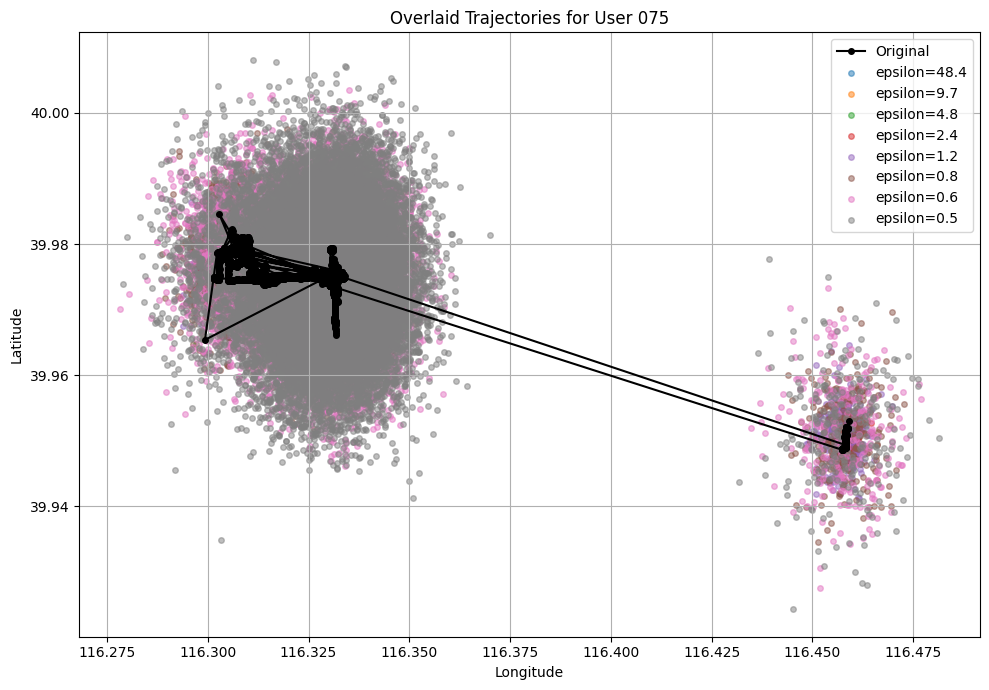

In [134]:
plt.figure(figsize=(10, 7))

# flatten all trajectories
lat_orig = [p[0] for traj in user_trajs for p in traj]
lon_orig = [p[1] for traj in user_trajs for p in traj]
plt.plot(lon_orig, lat_orig, marker='o', markersize=4, linewidth=1.5, label='Original', color='black')

for epsilon in epsilons:
    noisy_trajs = gaussian_results[epsilon][user_id]
    lat_noisy = [p[0] for traj in noisy_trajs for p in traj]
    lon_noisy = [p[1] for traj in noisy_trajs for p in traj]
    plt.scatter(lon_noisy, lat_noisy, s=16, alpha=0.5, label=f'epsilon={epsilon}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Overlaid Trajectories for User {user_id}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Overlaid Trajectories for User {user_id}", dpi=300)
plt.show()


### 3.3 Evaluation

In [24]:
density = compute_density_similarity_all_users(user_trajectory, gaussian_results)
print("density done!")
avg_disp, disp_distribution = compute_average_displacement_all_users(user_trajectory, gaussian_results)
print("avg_disp done!")
haus = compute_hausdorff_all_users(user_trajectory, gaussian_results)
print("haus done!")

density done!
avg_disp done!
haus done!


In [25]:
# separate cell in case of crash
reid = compute_reid_risk_all_users(user_trajectory, gaussian_results)
print("reid done!")

reid done!


In [26]:
def combine_metric_results(avg_disp, haus, density, reid):
    return {
        "avg_disp": avg_disp,
        "hausdorff": haus,
        "density": density,
        "reid": reid
    }
gaussian_matrix = combine_metric_results(avg_disp, haus, density, reid)

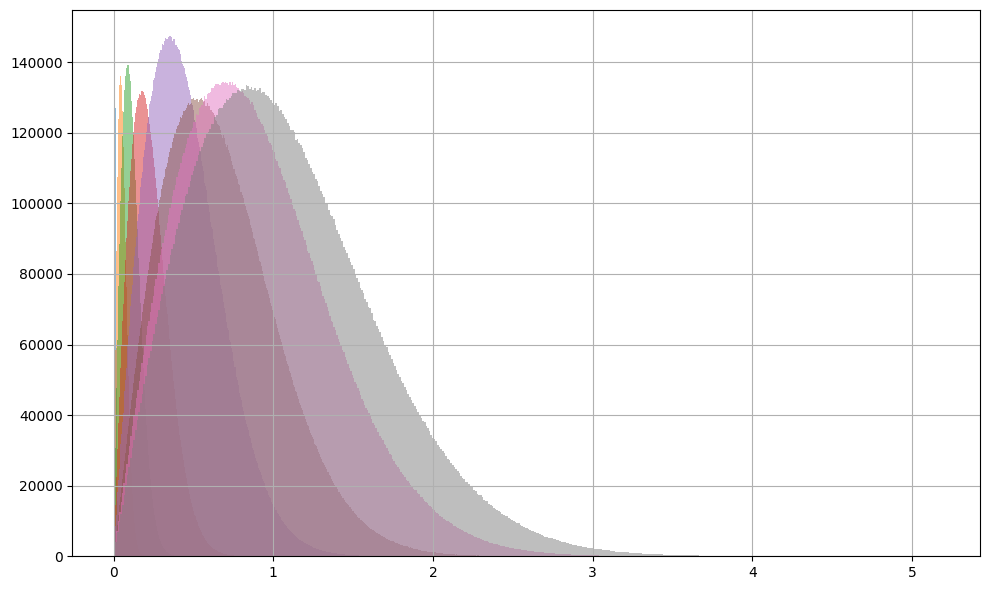

In [174]:
plt.figure(figsize=(10,6))
for epsilon, values in disp_distribution.items():
    plt.hist(values, bins=500, alpha=0.5, label=f"ε={epsilon}")
plt.grid(True)
plt.tight_layout()
plt.savefig("Noise distribution of part 1.png", dpi=300)
plt.show()

/var/folders/n7/vz1f3ct91hdgrxgt12vn6_s40000gn/T/ipykernel_4912/4047326592.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{lvl}" for lvl in noise_levels], rotation=45)


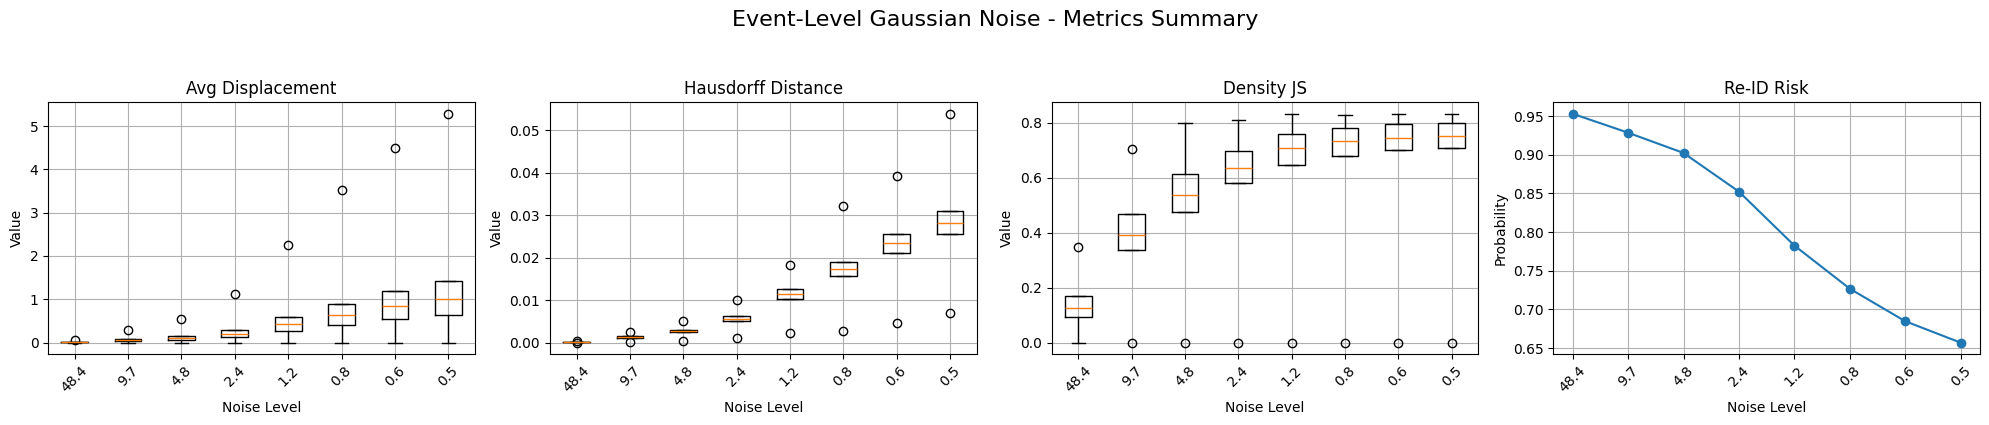

In [27]:
plot_all_metrics(gaussian_matrix, method_name="Event-Level Gaussian Noise")

### 4 Geo-Indistinguishability (planar Laplace)

How to choose espilon range?

In [20]:
epsilons = [0.1386, 0.0277, 0.0139, 0.0069, 0.0035, 0.0023, 0.0017, 0.0014]

In [22]:
l_privacy = np.log(4)   # from paper
[(l_privacy / eps) for eps in epsilons] # in meter

[10.002123817603827,
 50.0467278382632,
 99.73340727481228,
 200.9122262492595,
 396.08410317711156,
 602.7366787477786,
 815.4672712469945,
 990.210257942779]

In [24]:
geoind_results = apply_geoind_multi(user_trajectory, epsilons)

Applying Geo-Ind noise: noise level=0.1386
Applying Geo-Ind noise: noise level=0.0277
Applying Geo-Ind noise: noise level=0.0139
Applying Geo-Ind noise: noise level=0.0069
Applying Geo-Ind noise: noise level=0.0035
Applying Geo-Ind noise: noise level=0.0023
Applying Geo-Ind noise: noise level=0.0017
Applying Geo-Ind noise: noise level=0.0014
All Geo-Ind noise applied.



### 4.1 Histogram / Heatmap

### 4.1.1 sample user

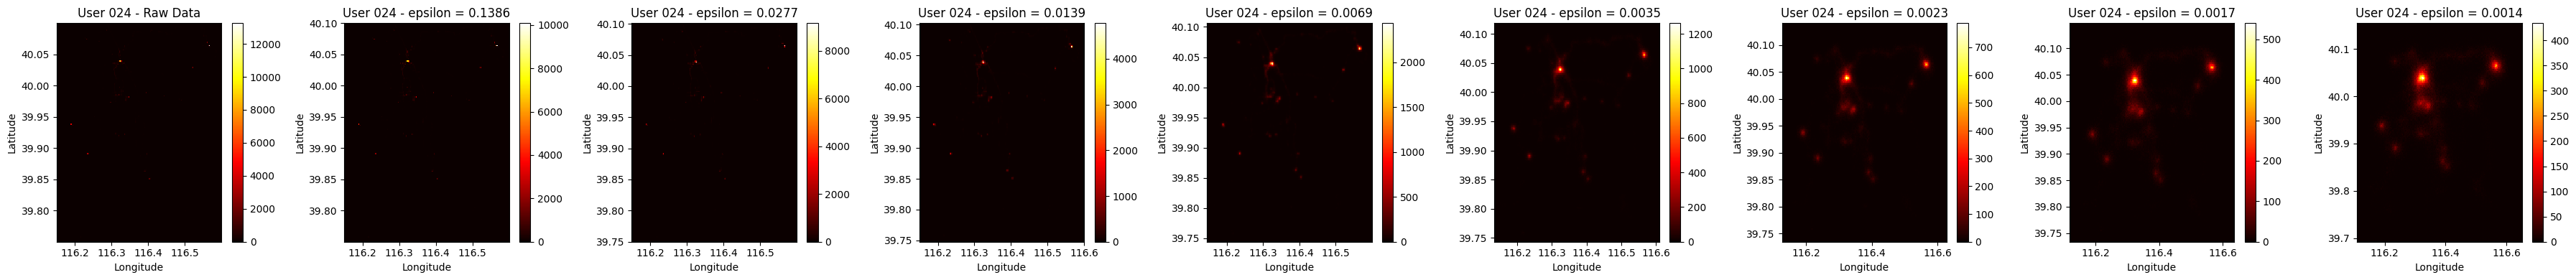

In [30]:
def plot_2d_hist(trajs, ax, title="", bins=200):
    # flatten all trajectories into a single list of points
    all_points = [pt for traj in trajs for pt in traj]
    all_points = np.array(all_points)

    lat = all_points[:, 0]
    lon = all_points[:, 1]

    heat = ax.hist2d(lon, lat, bins=bins, cmap="hot")
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(heat[3], ax=ax)


user_id = "024"
user_trajs = user_trajectory[user_id]
fig, axes = plt.subplots(1, len(epsilons) + 1, figsize=(4*(len(epsilons)+1), 4))

plot_2d_hist(user_trajs, axes[0], title=f"User {user_id} - Raw Data")

for i, epsilon in enumerate(epsilons):
    noisy_trajs = geoind_results[epsilon][user_id]  # only this user's noisy trajectories
    plot_2d_hist(noisy_trajs, axes[i+1], title=f"User {user_id} - epsilon = {epsilon}")

plt.tight_layout()
plt.savefig("Sample user Heatmap Geo-Ind.png", dpi=300)
plt.show()


### 4.1.2 all users in one plot

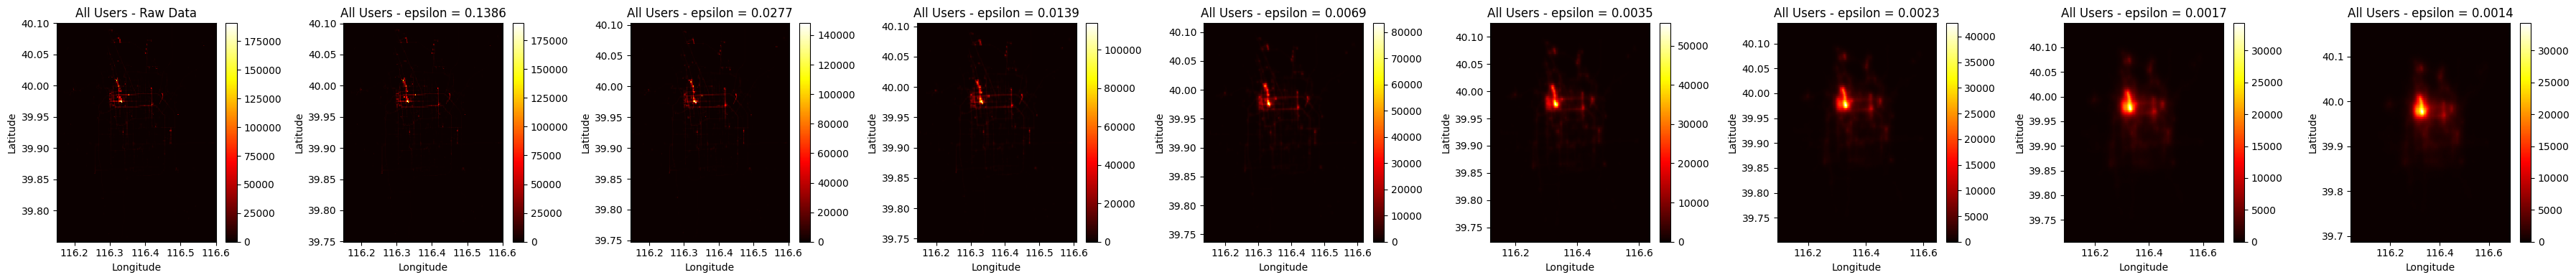

In [32]:
all_raw_trajs = [traj for user_trajs in user_trajectory.values() for traj in user_trajs]

fig, axes = plt.subplots(1, len(epsilons) + 1, figsize=(4*(len(epsilons)+1), 4))

plot_2d_hist(all_raw_trajs, axes[0], title="All Users - Raw Data")

for i, epsilon in enumerate(epsilons):
    all_noisy_trajs = [traj for trajs_per_user in geoind_results[epsilon].values() for traj in trajs_per_user]
    plot_2d_hist(all_noisy_trajs, axes[i+1], title=f"All Users - epsilon = {epsilon}")
    
plt.tight_layout()
plt.savefig("All users Heatmap Geo-Ind.png", dpi=300)
plt.show()

### 4.2 scatter plot

### 4.2.1 separate plot

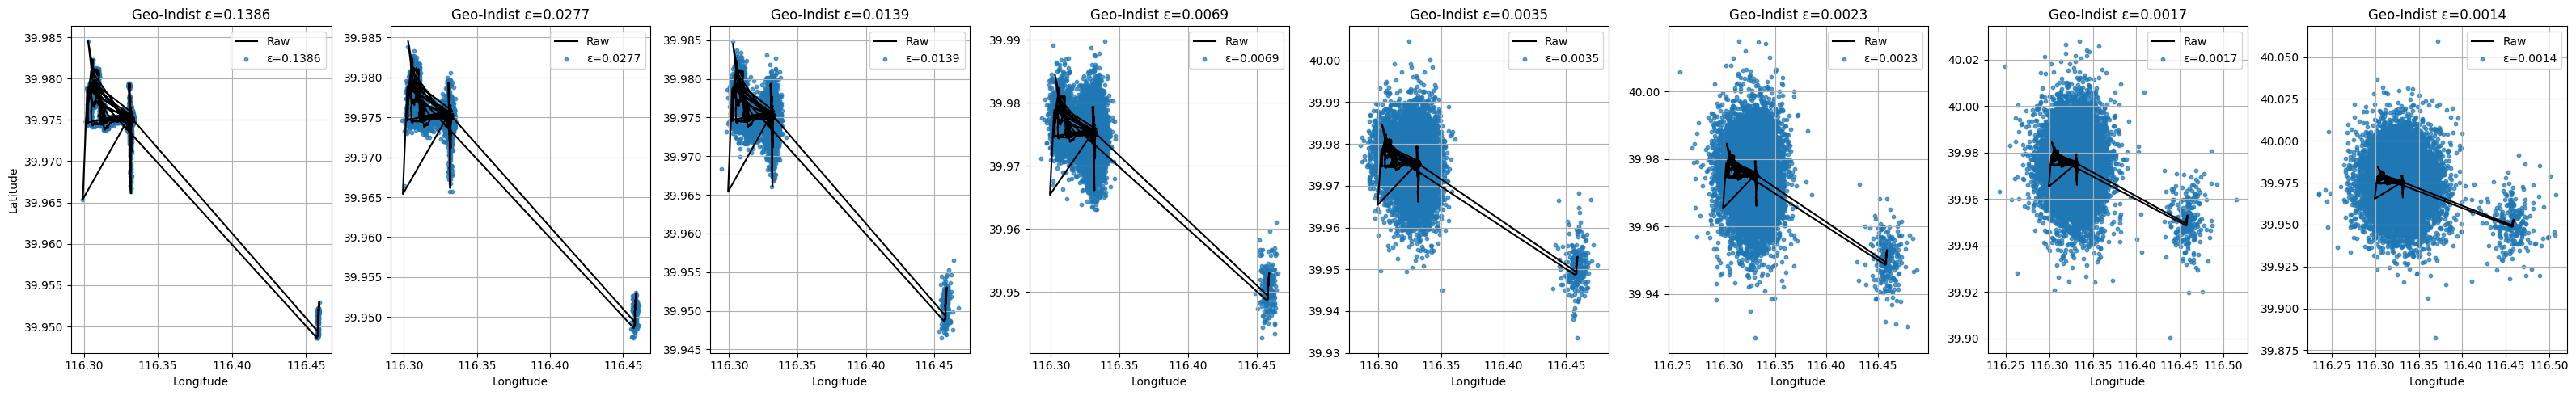

In [34]:
user_id = "075"
user_trajs = user_trajectory[user_id]

lat_orig = [p[0] for traj in user_trajs for p in traj]
lon_orig = [p[1] for traj in user_trajs for p in traj]

fig, axes = plt.subplots(1, len(epsilons), figsize=(4*len(epsilons), 5))

for i, epsilon in enumerate(epsilons):
    ax = axes[i]

    ax.plot(lon_orig, lat_orig, color="black", linewidth=1.5, label="Raw")

    noisy_trajs = geoind_results[epsilon][user_id]
    lat_noisy = [p[0] for traj in noisy_trajs for p in traj]
    lon_noisy = [p[1] for traj in noisy_trajs for p in traj]

    ax.scatter(lon_noisy, lat_noisy, s=10, alpha=0.7, label=f"ε={epsilon}")

    ax.set_title(f"Geo-Indist ε={epsilon}")
    ax.set_xlabel("Longitude")
    if i == 0:
        ax.set_ylabel("Latitude")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("Scatter plot for sample user(separate) Geo-Ind.png", dpi=300)
plt.show()


### 4.2.2 all in one plot

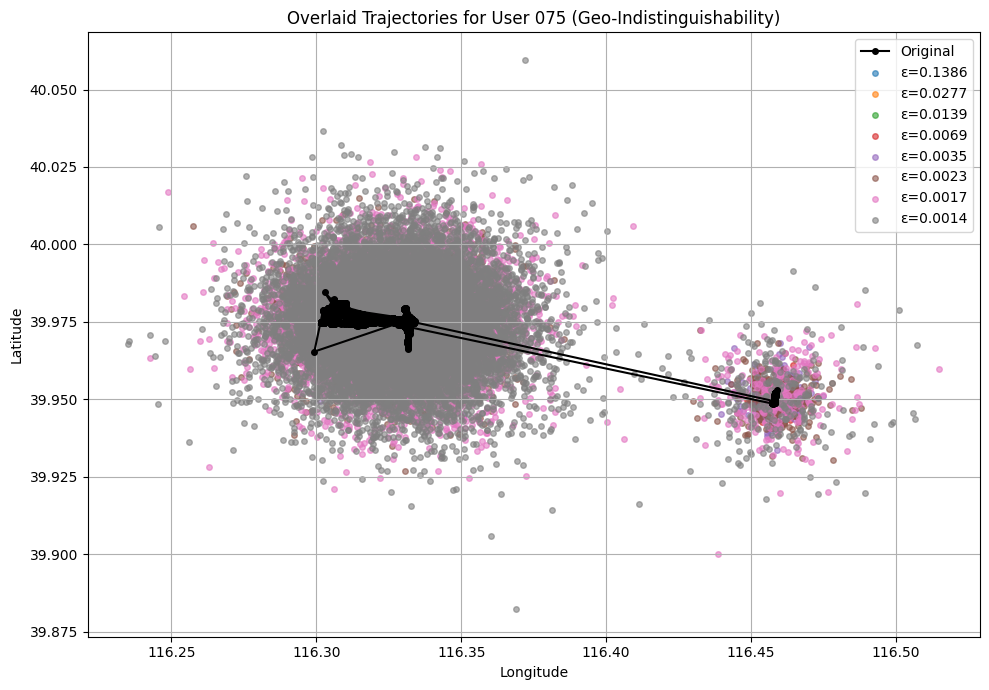

In [36]:
plt.figure(figsize=(10, 7))

lat_orig = [p[0] for traj in user_trajs for p in traj]
lon_orig = [p[1] for traj in user_trajs for p in traj]
plt.plot(lon_orig, lat_orig, marker='o', markersize=4, linewidth=1.5, label='Original', color='black')

for epsilon in epsilons:
    noisy_trajs = geoind_results[epsilon][user_id]
    lat_noisy = [p[0] for traj in noisy_trajs for p in traj]
    lon_noisy = [p[1] for traj in noisy_trajs for p in traj]
    plt.scatter(lon_noisy, lat_noisy, s=16, alpha=0.6, label=f'ε={epsilon}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Overlaid Trajectories for User {user_id} (Geo-Indistinguishability)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Overlaid Trajectories for User Geo-Ind", dpi=300)
plt.show()


### 4.3 evaluation

In [40]:
avg_disp_geo, disp_distribution_geo = compute_average_displacement_all_users(user_trajectory, geoind_results)
print("avg_disp done!")
haus_geo = compute_hausdorff_all_users(user_trajectory, geoind_results)
print("haus done!")
density_geo = compute_density_similarity_all_users(user_trajectory, geoind_results)
print("density done!")

avg_disp done!
haus done!
density done!


In [43]:
reid_geo = compute_reid_risk_all_users(user_trajectory, geoind_results)
print("reid done!\n")

reid done!



In [47]:
def combine_metric_results(avg_disp, haus, density, reid):
    return {
        "avg_disp": avg_disp,
        "hausdorff": haus,
        "density": density,
        "reid": reid
    }
geoind_matrix = combine_metric_results(avg_disp_geo, haus_geo, density_geo, reid_geo)

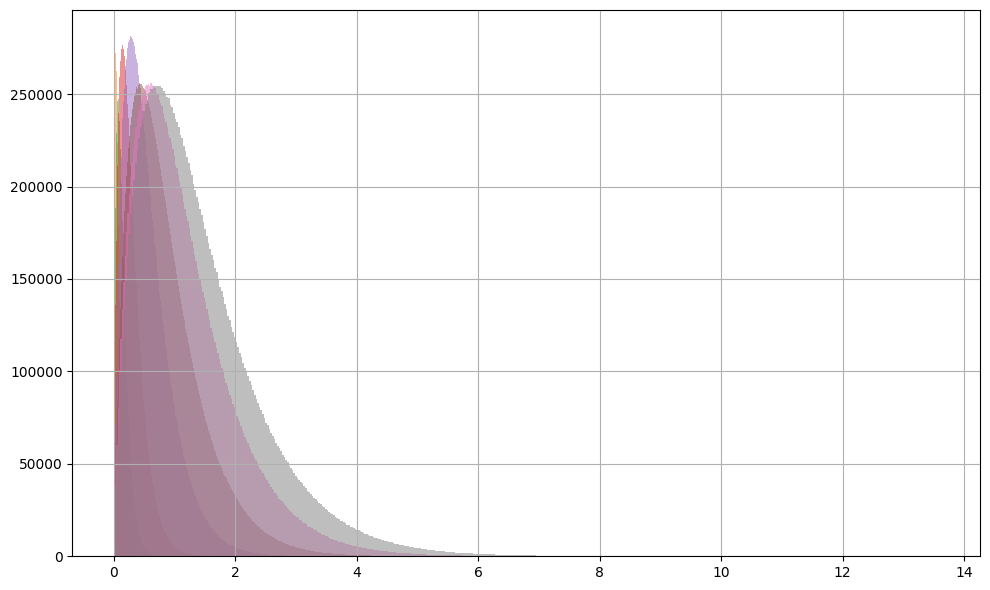

In [53]:
plt.figure(figsize=(10,6))
for epsilon, values in disp_distribution_geo.items():
    plt.hist(values, bins=500, alpha=0.5, label=f"ε={epsilon}")
plt.grid(True)
plt.tight_layout()
plt.savefig("Noise distribution of Geo-Ind.png", dpi=300)
plt.show()

/var/folders/n7/vz1f3ct91hdgrxgt12vn6_s40000gn/T/ipykernel_3581/4047326592.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{lvl}" for lvl in noise_levels], rotation=45)


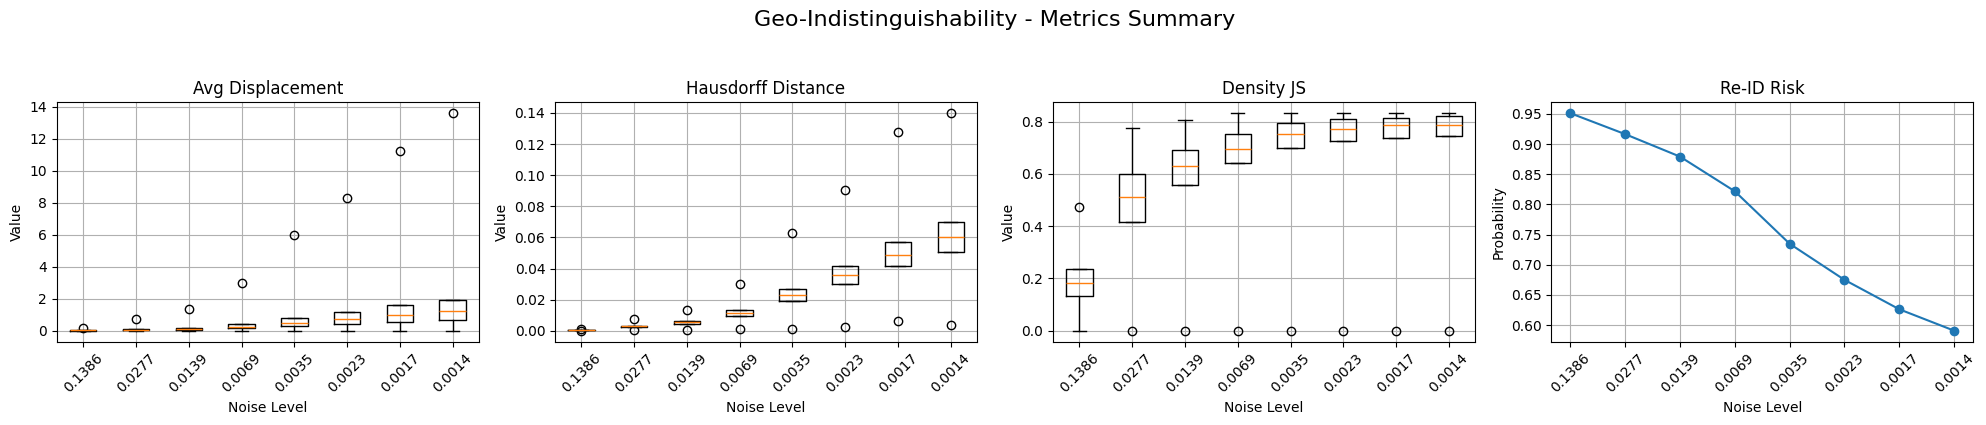

In [49]:
plot_all_metrics(geoind_matrix, method_name="Geo-Indistinguishability")

### 5 trajectory DP noise

In [18]:
epsilons = [48.4, 9.7, 4.8, 2.4, 1.2, 0.8, 0.6, 0.5]

In [20]:
traj_results = apply_traj_multi(user_trajectory, epsilons)

Applying Trajectory-level gaussian noise: epsilon=48.4
Applying Trajectory-level gaussian noise: epsilon=9.7
Applying Trajectory-level gaussian noise: epsilon=4.8
Applying Trajectory-level gaussian noise: epsilon=2.4
Applying Trajectory-level gaussian noise: epsilon=1.2
Applying Trajectory-level gaussian noise: epsilon=0.8
Applying Trajectory-level gaussian noise: epsilon=0.6
Applying Trajectory-level gaussian noise: epsilon=0.5
All trajectory-level noise applied.



### 5.1 Histogram / Heatmap

### 5.1.1 sample user

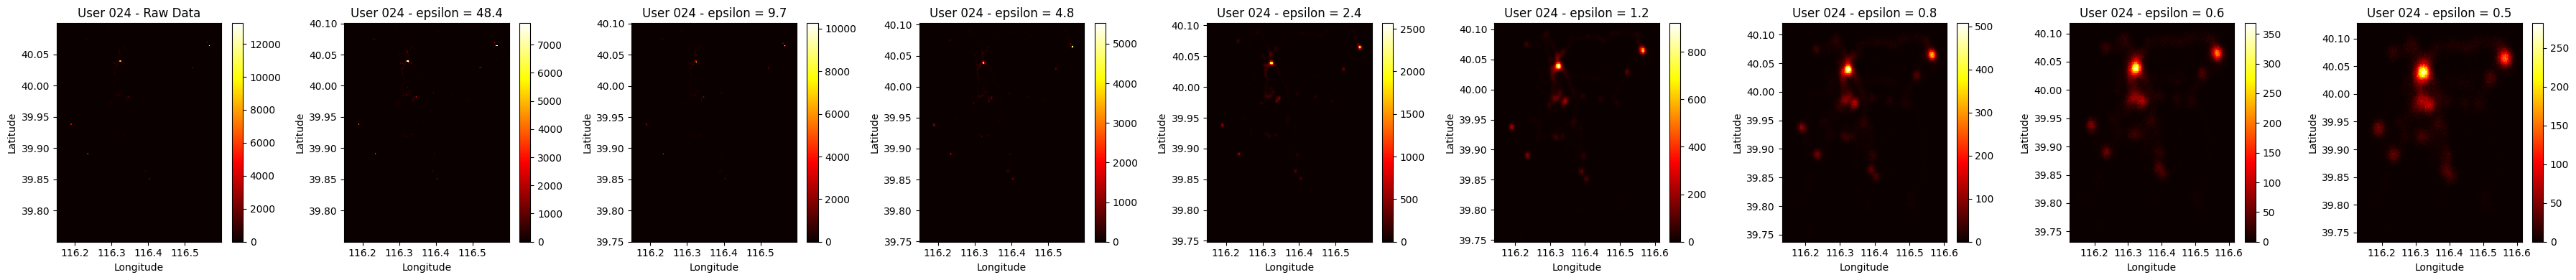

In [23]:
def plot_2d_hist(trajs, ax, title="", bins=200):
    # flatten all trajectories into a single list of points
    all_points = [pt for traj in trajs for pt in traj]
    all_points = np.array(all_points)

    lat = all_points[:, 0]
    lon = all_points[:, 1]

    heat = ax.hist2d(lon, lat, bins=bins, cmap="hot")
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.colorbar(heat[3], ax=ax)

user_id = "024"
user_trajs = user_trajectory[user_id]

fig, axes = plt.subplots(1, len(epsilons) + 1, figsize=(4*(len(epsilons)+1), 4))

plot_2d_hist(user_trajs, axes[0], title=f"User {user_id} - Raw Data")

for i, epsilon in enumerate(epsilons):
    noisy_trajs = traj_results[epsilon][user_id]  # only this user's noisy trajectories
    plot_2d_hist(noisy_trajs, axes[i+1], title=f"User {user_id} - epsilon = {epsilon}")

plt.tight_layout()
plt.savefig("Sample Heatmap 3.png", dpi=300)
plt.show()


### 5.1.2 all users in one plot

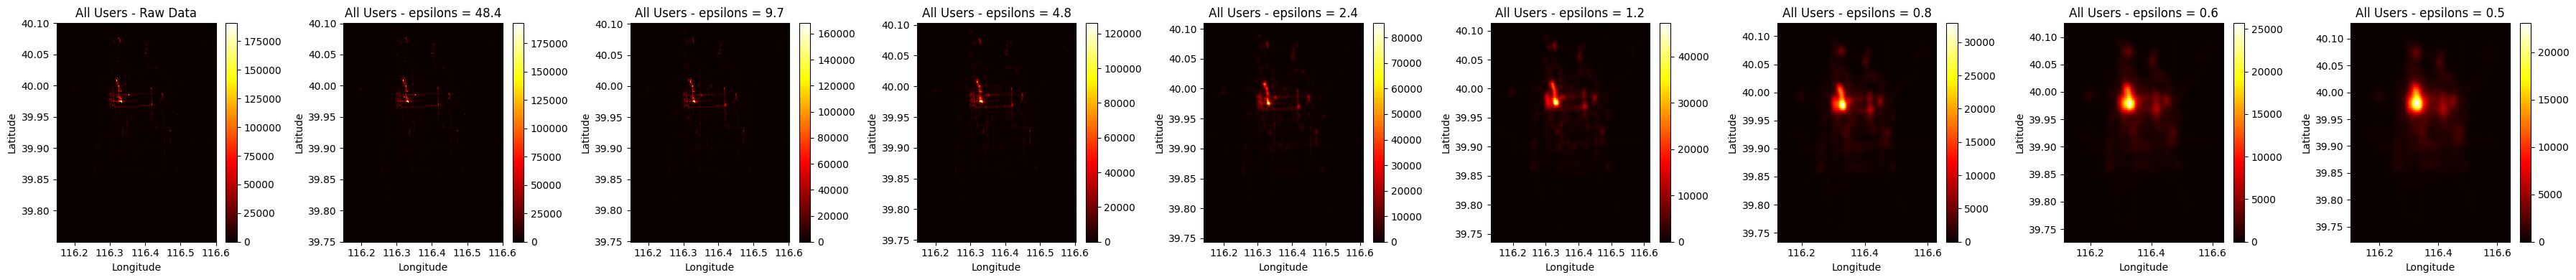

In [25]:
all_raw_trajs = [traj for user_trajs in user_trajectory.values() for traj in user_trajs]

fig, axes = plt.subplots(1, len(epsilons) + 1, figsize=(4*(len(epsilons)+1), 4))

plot_2d_hist(all_raw_trajs, axes[0], title="All Users - Raw Data")

for i, epsilon in enumerate(epsilons):
    all_noisy_trajs = [traj for trajs_per_user in traj_results[epsilon].values() for traj in trajs_per_user]
    plot_2d_hist(all_noisy_trajs, axes[i+1], title=f"All Users - epsilons = {epsilon}")

plt.tight_layout()
plt.savefig("All Heatmap 3.png", dpi=500)
plt.show()

### 5.2 scatter plot

### 5.2.1 separate plot

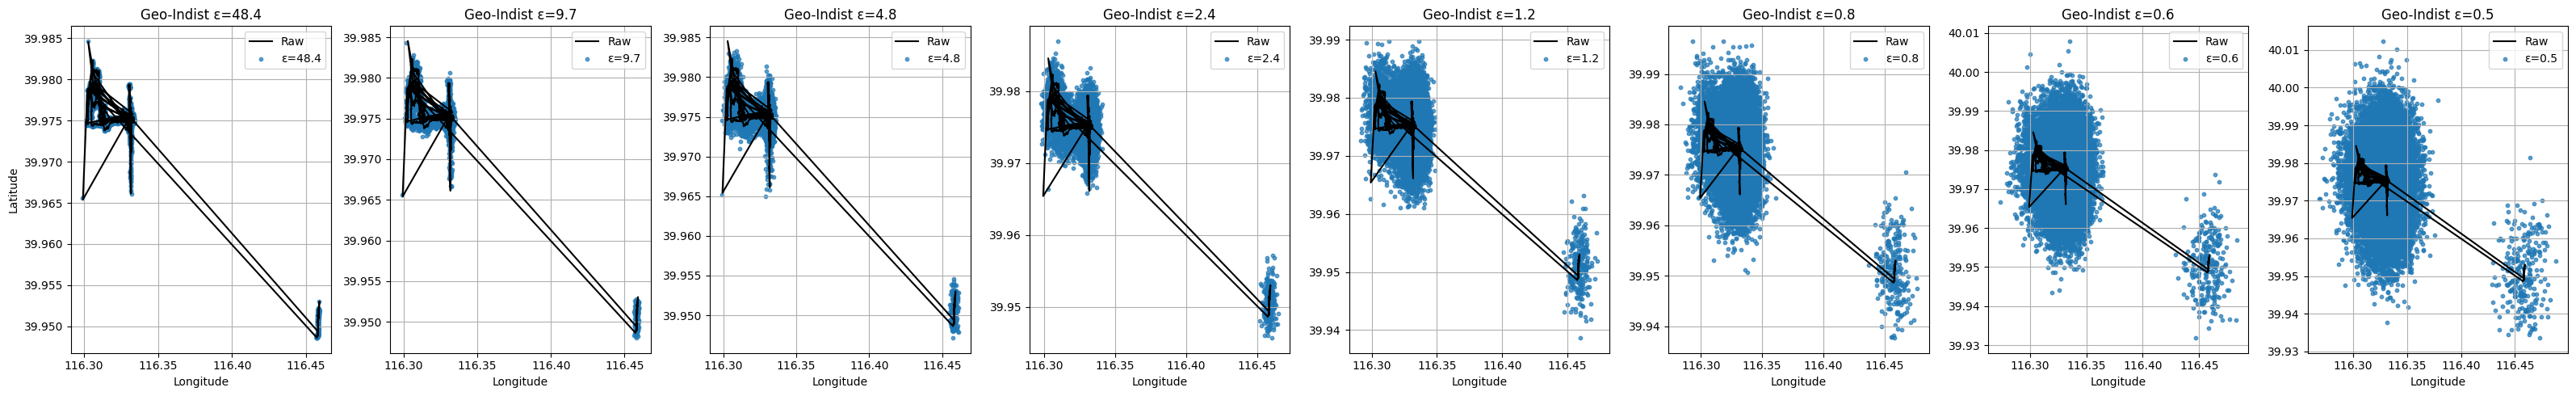

In [29]:
user_id = "075"
user_trajs = user_trajectory[user_id]

lat_orig = [p[0] for traj in user_trajs for p in traj]
lon_orig = [p[1] for traj in user_trajs for p in traj]

fig, axes = plt.subplots(1, len(epsilons), figsize=(4*len(epsilons), 5))

for i, epsilon in enumerate(epsilons):
    ax = axes[i]

    ax.plot(lon_orig, lat_orig, color="black", linewidth=1.5, label="Raw")

    noisy_trajs = traj_results[epsilon][user_id]
    lat_noisy = [p[0] for traj in noisy_trajs for p in traj]
    lon_noisy = [p[1] for traj in noisy_trajs for p in traj]

    ax.scatter(lon_noisy, lat_noisy, s=10, alpha=0.7, label=f"ε={epsilon}")

    ax.set_title(f"Geo-Indist ε={epsilon}")
    ax.set_xlabel("Longitude")
    if i == 0:
        ax.set_ylabel("Latitude")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig("Sample Scatter 3.png", dpi=300)
plt.show()


### 5.2.2 all in one plot

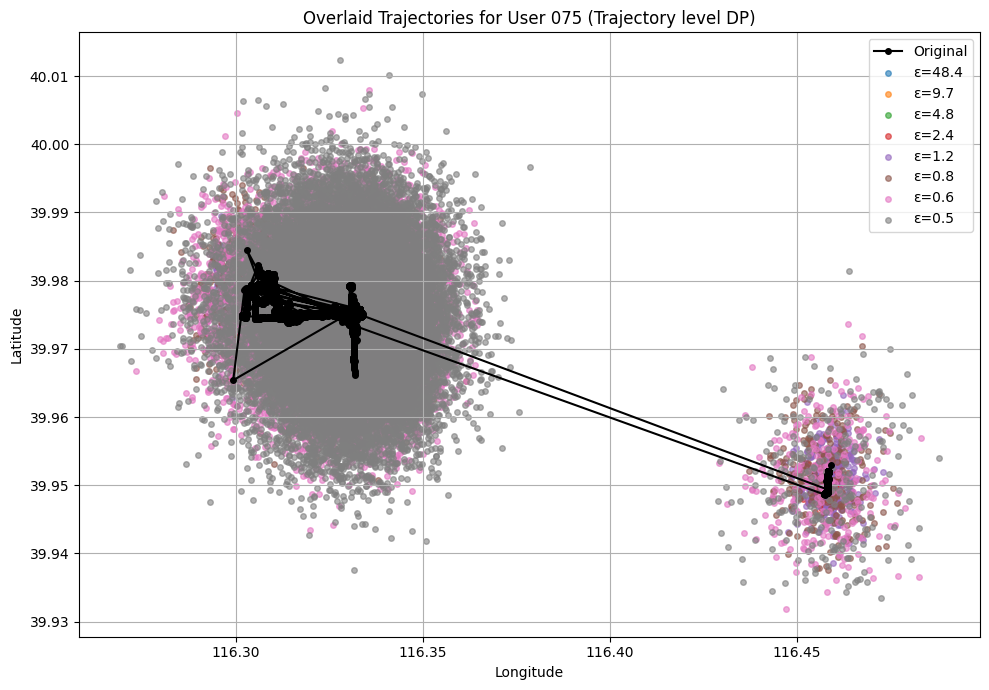

In [31]:
plt.figure(figsize=(10, 7))

lat_orig = [p[0] for traj in user_trajs for p in traj]
lon_orig = [p[1] for traj in user_trajs for p in traj]
plt.plot(lon_orig, lat_orig, marker='o', markersize=4, linewidth=1.5, label='Original', color='black')

for epsilon in epsilons:
    noisy_trajs = traj_results[epsilon][user_id]
    lat_noisy = [p[0] for traj in noisy_trajs for p in traj]
    lon_noisy = [p[1] for traj in noisy_trajs for p in traj]
    plt.scatter(lon_noisy, lat_noisy, s=16, alpha=0.6, label=f'ε={epsilon}')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Overlaid Trajectories for User {user_id} (Trajectory level DP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Overlaid 3.png", dpi=300)
plt.show()


### 5.3 evaluation

In [33]:
avg_disp_traj, avg_distribution_traj = compute_average_displacement_all_users(user_trajectory, traj_results)
print("avg_disp done!")
haus_traj = compute_hausdorff_all_users(user_trajectory, traj_results)
print("haus done!")
density_traj = compute_density_similarity_all_users(user_trajectory, traj_results)
print("density done!")

avg_disp done!
haus done!
density done!


In [34]:
reid_traj = compute_reid_risk_all_users(user_trajectory, traj_results)
print("reid done!\n")

reid done!



In [36]:
def combine_metric_results(avg_disp, haus, density, reid):
    return {
        "avg_disp": avg_disp,
        "hausdorff": haus,
        "density": density,
        "reid": reid
    }
traj_matrix = combine_metric_results(avg_disp_traj, haus_traj, density_traj, reid_traj)

/var/folders/n7/vz1f3ct91hdgrxgt12vn6_s40000gn/T/ipykernel_5501/4047326592.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{lvl}" for lvl in noise_levels], rotation=45)


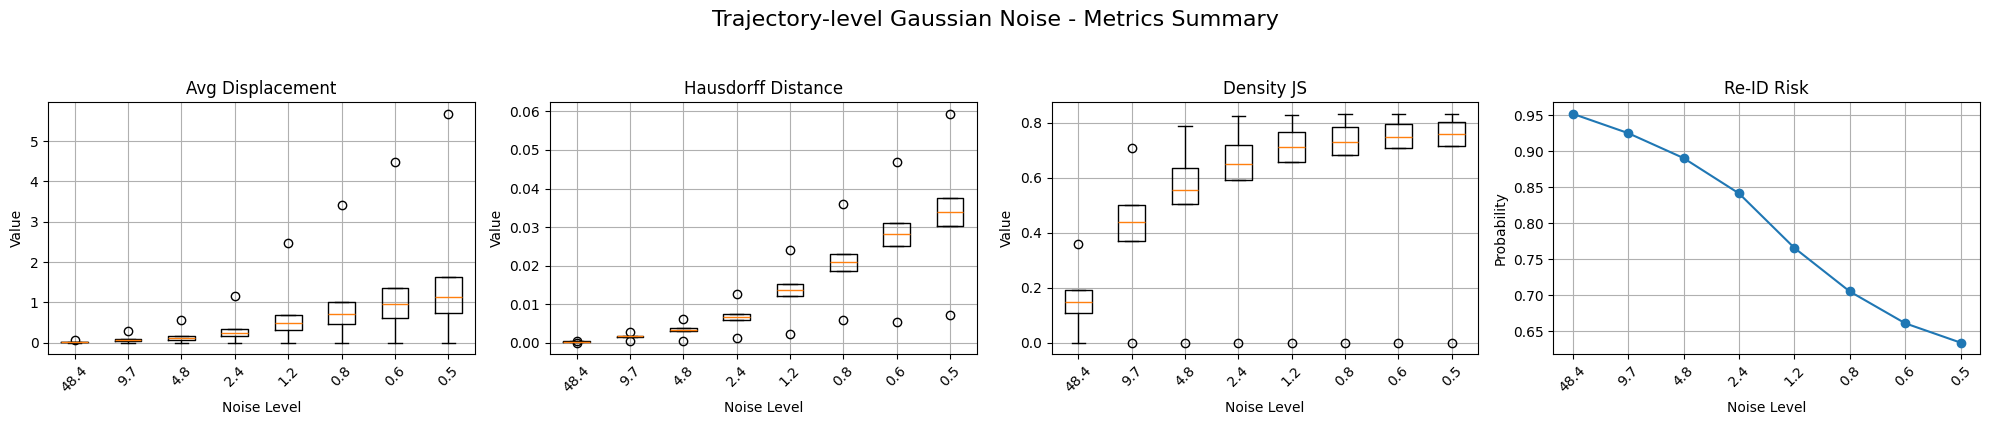

In [39]:
plot_all_metrics(traj_matrix, method_name="Trajectory-level Gaussian Noise")

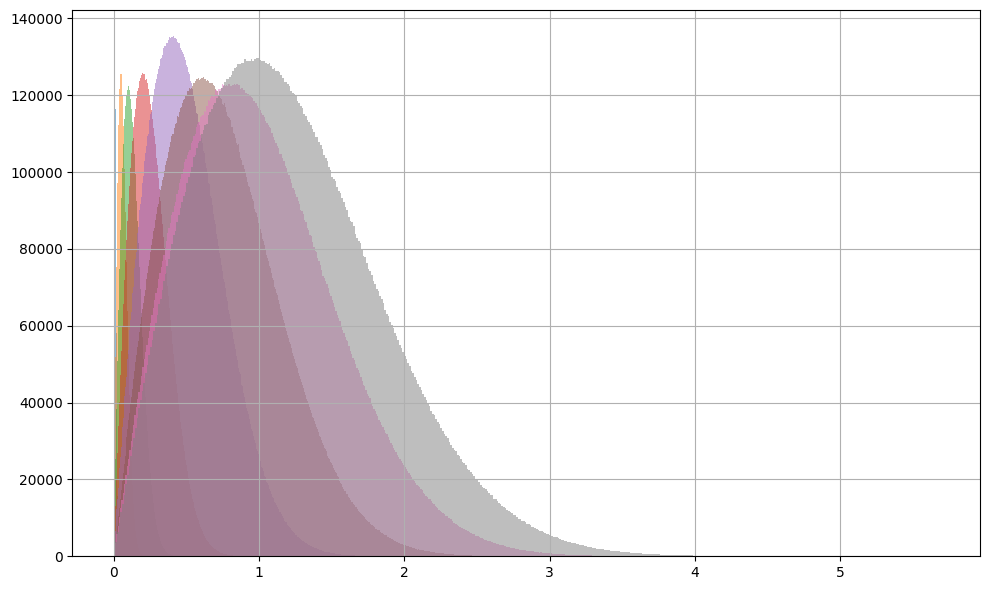

In [45]:
plt.figure(figsize=(10,6))
for epsilon, values in avg_distribution_traj.items():
    plt.hist(values, bins=500, alpha=0.5, label=f"ε={epsilon}")
plt.grid(True)
plt.tight_layout()
plt.savefig("Noise distribution 3.png", dpi=300)
plt.show()